# backtrader教程

**by Zoe**

<br />
<br />
<br />

backtrader是基于Python的量化框架平台，内置了talib指标库、analyzer分析库等功能，具有回测速度快、易用性高以及扩展性好等特点。相较于网上已有教程，本教程从数据至分析进行了全面的介绍，着重阐述了数据清洗以及框架调整等部分，点出了backtrader的某些不足并提供了解决方法。
<br />

In [1]:
from datetime import datetime
import backtrader as bt
import tushare as ts
import pandas as pd
from backtrader.feeds import PandasData

## 1. 数据加载
### 1.1. data collecting

backtrader支持Yahoo等online的数据源和本地数据源。大家也可以自己造轮子，接wind,tushare等。
backtrader要求至少含有7列数据，包括datetime，open，high，low，close，volume，openinterest。本文把datetime设为了index。

本文拉前复权数据，前复权就是从后往前复权，所以复权后最近的价格保持一致。至于后复权，vice versa。有些数据源的前复权机制会有负数的存在，这是因为计算复权的时候是价格减去了分红，而不是用的累计复权因子，https://xueqiu.com/3488649239/62074848 这篇文章已经介绍得很详细，本文就不抛砖引玉了。注意：在用累计因子的情况下，前后复权的选择不影响收益率。

In [2]:
# tushare
def get_single_kdata(code, start='2020-01-01', end='2021-08-18', index=False):
    df = ts.get_k_data(code, autype='qfq', start=start, end=end, index=index)
    df['date'] = pd.to_datetime(df['date'])
    df['openinterest'] = 0
    return df[['date', 'open', 'high', 'low', 'close', 'volume', 'openinterest']]

# # yahoo
# def get_single_kdata(code, start='2020-01-01', end='2021-08-18'):
#     df = bt.feeds.YahooFinanceData(
#             dataname='AAPL',
#             fromdate=datetime.strptime(start,'%Y-%m-%d'),
#             todate=datetime.strptime(end,'%Y-%m-%d'),
#             adjclose=True,
#             adjvolume=True)
#     return df

In [3]:
secu_lst = ['600000','000001']
kdata = {}
for secu in secu_lst:
    kdata[secu] = get_single_kdata(secu)
    
print(kdata['000001'].head())

        date   open   high    low  close     volume  openinterest
0 2020-01-02  16.65  16.95  16.55  16.87  1530231.0             0
1 2020-01-03  16.94  17.31  16.92  17.18  1116194.0             0
2 2020-01-06  17.01  17.34  16.91  17.07   862083.0             0
3 2020-01-07  17.13  17.28  16.95  17.15   728607.0             0
4 2020-01-08  17.00  17.05  16.63  16.66   847824.0             0


对于一个策略，股票池常常是不断变化的，不可能只有一个起点和终点。

In [4]:
# 如果你想要的不同的start和end
# 自己定义
secu_lst = {'600000':{'start':'2020-01-01','end':'2020-07-18'},
            '000001':{'start':'2020-02-01','end':'2020-08-18'}}
kdata = {}
for secu in secu_lst.keys():
    kdata[secu] = get_single_kdata(secu, secu_lst[secu]['start'], secu_lst[secu]['end']).reset_index(drop=True)
    
print(kdata['000001'].head())

        date   open   high    low  close     volume  openinterest
0 2020-02-03  13.99  14.70  13.99  13.99  2259194.0             0
1 2020-02-04  14.05  14.66  14.02  14.60  1706172.0             0
2 2020-02-05  14.59  14.89  14.32  14.63  1491380.0             0
3 2020-02-06  14.81  14.87  14.51  14.77  1185815.0             0
4 2020-02-07  14.60  14.69  14.41  14.62   924852.0             0


### 1.2. data cleansing and processing

上述股票的日期并没有对齐，造成开始停止日不同的原因还有股池的筛选条件、新股上市、股票停牌等。而backtrader的运作机制next()需要all data都满足最小周期，否则需要调用prenext()。本文建议一个更简单的方法，补充数据使所有股票拥有同样的周期，并同时标注停牌日。

In [5]:
# 先拿大盘trading_dates
benchmark_start = min(secu_lst.values(), key=lambda x : x['start'])['start']
benchmark_end = max(secu_lst.values(), key=lambda x : x['end'])['end']
print(f"start: {benchmark_start}, end {benchmark_end}")

benchmark = '399905' # 中证500
kdata['benchmark'] = get_single_kdata(benchmark, benchmark_start, benchmark_end, index=True) 
trading_dates = kdata['benchmark']['date'].tolist()
print(f"start: {trading_dates[0]}, end {trading_dates[-1]}")

start: 2020-01-01, end 2020-08-18
start: 2020-01-02 00:00:00, end 2020-08-18 00:00:00


In [6]:
for secu in set(kdata.keys())-set(['benchmark']):
    print(secu)
    secu_kdata = kdata['benchmark'][['date']].merge(kdata[secu],how='left')
    secu_kdata['suspend'] = 0 
    secu_kdata.loc[secu_kdata['open'].isnull(), 'suspend'] = 1 # 标记为停盘日
    secu_kdata.set_index(['date'], inplace = True) # 设date为index
    end = secu_lst[secu]['end']
    secu_kdata.fillna(method='ffill',inplace = True) # start后的数据用前日数据进行补充
    secu_kdata.fillna(value = 0,inplace = True) #start前的数据用0补充
    secu_kdata.loc[(secu_kdata.index > end), 'suspend'] = 1
    print(secu_kdata)
    kdata[secu] = secu_kdata

000001
             open   high    low  close     volume  openinterest  suspend
date                                                                    
2020-01-02   0.00   0.00   0.00   0.00        0.0           0.0        1
2020-01-03   0.00   0.00   0.00   0.00        0.0           0.0        1
2020-01-06   0.00   0.00   0.00   0.00        0.0           0.0        1
2020-01-07   0.00   0.00   0.00   0.00        0.0           0.0        1
2020-01-08   0.00   0.00   0.00   0.00        0.0           0.0        1
...           ...    ...    ...    ...        ...           ...      ...
2020-08-12  14.21  14.50  14.15  14.38  1596812.0           0.0        0
2020-08-13  14.40  14.46  14.14  14.18   837262.0           0.0        0
2020-08-14  14.10  14.51  14.06  14.47  1103216.0           0.0        0
2020-08-17  14.60  15.35  14.55  15.19  3268028.0           0.0        0
2020-08-18  15.20  15.30  14.91  15.15  1350261.0           0.0        0

[152 rows x 7 columns]
600000
             

股票池的筛选也同理，补充数据就ok，但要注意，end是剔除日的后一根bar的日期。
整理成一个class会更清晰一点

In [7]:
class GetKdatas(object):
    def __init__(self, secu_lst, benchmark='000001'):
        """
        :parameter secu_lst: a dict contained stocks with starts and ends
        :parameter benchmark: the name of benchmark
        """
        self.secu_lst = secu_lst
        self.benchmark = benchmark

    @staticmethod
    def get_single_kdata(code, start='2020-01-01', end='2021-08-18', index=False):
        df = ts.get_k_data(code, autype='qfq', start=start, end=end, index=index)
        df['date'] = pd.to_datetime(df['date'])
        df['openinterest'] = 0
        return df[['date', 'open', 'high', 'low', 'close', 'volume', 'openinterest']]

    def get_all_kdata(self):
        kdata = {}
        for secu in set(self.secu_lst):
            secu_kdata = self.get_single_kdata(secu, self.secu_lst[secu]['start'], self.secu_lst[secu]['end'])
            kdata[secu] = secu_kdata.reset_index(drop=True)
        return kdata

    def merge_period(self):
        all_kdata = self.get_all_kdata()
        benchmark_start = min(self.secu_lst.values(), key=lambda x: x['start'])['start']
        benchmark_end = max(self.secu_lst.values(), key=lambda x: x['end'])['end']
        all_kdata['benchmark'] = self.get_single_kdata(self.benchmark, benchmark_start, benchmark_end,True)

        for secu in set(all_kdata.keys()) - set(['benchmark']):
            secu_kdata = all_kdata['benchmark'][['date']].merge(all_kdata[secu], how='left')
            secu_kdata['suspend'] = 0
            secu_kdata.loc[secu_kdata['open'].isnull(), 'suspend'] = 1  # 标记为停盘日
            secu_kdata.set_index(['date'], inplace=True)  # 设date为index
            end = secu_lst[secu]['end']
            secu_kdata.fillna(method='ffill', inplace=True)  # start后的数据用前日数据进行补充
            secu_kdata.fillna(value=0, inplace=True)  # start前的数据用0补充
            secu_kdata.loc[(secu_kdata.index > end), 'suspend'] = 1
            all_kdata[secu] = secu_kdata

        _ = all_kdata.pop('benchmark')
        return all_kdata

In [8]:
secu_lst = {'600000': {'start': '2020-01-01', 'end': '2020-07-18'},
            '000001': {'start': '2020-02-01', 'end': '2020-08-18'}}

kdata = GetKdatas(secu_lst).merge_period()
print(kdata)

{'000001':              open   high    low  close     volume  openinterest  suspend
date                                                                    
2020-01-02   0.00   0.00   0.00   0.00        0.0           0.0        1
2020-01-03   0.00   0.00   0.00   0.00        0.0           0.0        1
2020-01-06   0.00   0.00   0.00   0.00        0.0           0.0        1
2020-01-07   0.00   0.00   0.00   0.00        0.0           0.0        1
2020-01-08   0.00   0.00   0.00   0.00        0.0           0.0        1
...           ...    ...    ...    ...        ...           ...      ...
2020-08-12  14.21  14.50  14.15  14.38  1596812.0           0.0        0
2020-08-13  14.40  14.46  14.14  14.18   837262.0           0.0        0
2020-08-14  14.10  14.51  14.06  14.47  1103216.0           0.0        0
2020-08-17  14.60  15.35  14.55  15.19  3268028.0           0.0        0
2020-08-18  15.20  15.30  14.91  15.15  1350261.0           0.0        0

[152 rows x 7 columns], '600000':      


### 1.3. data feeding

接下来就是放入数据，backtrader默认仅datetime，open，high，low，close，volume，openinterest这7列。
<br/>
默认顺序为open (default: 1) , high (default: 2), low (default: 3), close (default: 4), volume (default: 5), openinterest (default: 6)。
<br/>
一定，一定要记得在add时加入*name=secu*，不然回溯股票的代码很麻烦

In [9]:
cerebro = bt.Cerebro()
for secu in set(kdata.keys())-set(['benchmark']):
    df = PandasData(dataname=kdata[secu], fromdate=kdata[secu].index[0],todate=kdata[secu].index[-1])
    cerebro.adddata(df, name=secu) 

# 如果是本地csv，如果你的column是和默认一样的，那从datetime开始都不用写，否则必须指明
# data = btfeeds.GenericCSVData(
#     dataname='mydata.csv',
#     fromdate=benchmark_start,
#     todate=benchmark_end,
#     dtformat=('%Y-%m-%d'),
#     datetime=0,
#     high=1,
#     low=2,
#     open=3,
#     close=4,
#     volume=5,
#     openinterest=-1
# )

**如果你要增添其他的指标，可以根据以下模块。注意放入数据的时候是PandasData_Extend。如果是load本地文件，就把PandasData换成GenericCSVData，序号从序列8开始。

In [10]:
class PandasData_Extend(PandasData):
     # Add a 'suspend' line to the inherited ones from the base class
    lines = ('suspend',)
    # 现在是(open,0), ... , (openinterest,5)这6列，所以增加1
    # add the parameter to the parameters inherited from the base class
    params = (('suspend', 6),)
    
    # 如果是csv文档，openinterest 在 GenericCSVData index是7，所以1
    # params = (('suspend', 8),)


## 2. 框架介绍
### 2.1. 初始资金、买卖佣金设置

初始资金默认10000，但众所周知，初始金额的大小会影响整个策略收益。如果过小，会买不进某些大盘股。如果过大，会导致小盘股的买入划价增加很多，甚至无法购买预期数量的小盘股，因此需要设置初始资金。

In [11]:
cerebro = bt.Cerebro()
# 设置初始资本为1 million
startcash = 10**6
cerebro.broker.setcash(startcash)
print(f"初始资金{cerebro.broker.getvalue()}")

初始资金1000000


费率也是一大问题，券商佣金最低收五元，沪市过户费最低收一元。不要小看这些费率，当你做高频交易的时候，你的利润可能大都被这些费率吃掉了。
<br/>
本文为简略，过户费没有进行对市场的判断。如需，加上判断即可。

In [12]:
class CommInfoPro(bt.CommInfoBase):

    params = (
        ('stamp_duty', 0.001),  # 印花税率
        ('stamp_duty_fe', 1),  # 最低印花税
        ('commission', 0.001),  # 佣金率
        ('commission_fee', 5),  # 最低佣金费
        ('stocklike', True), # 股票
        ('commtype', bt.CommInfoBase.COMM_PERC), # 按比例收
    )

    def _getcommission(self, size, price, pseudoexec):
        '''
        If size is greater than 0, this indicates a long / buying of shares.
        If size is less than 0, it idicates a short / selling of shares.
        '''

        if size > 0:  # 买入，不考虑印花税
            return max(size * price * self.p.commission, self.p.commission_fee)
        elif size < 0:  # 卖出，考虑印花税
            return max(size * price * (self.p.stamp_duty + self.p.commission), self.p.stamp_duty_fe)
        else:
            return 0  # just in case for some reason the size is 0.

        
cerebro.broker.addcommissioninfo(CommInfoPro())

### 2.2. 下单函数调整
众所周知，A股市以每手100股成交的，所以order size必须为100的整数倍。因此我们在计算的时候也应该注意这一点。一种方法是在backtrader内部修改order函数，在计算amount的时候downcast，因为jupyter不好展示这一步骤。本文通过在order的时候计算这一amount来解决。

注意：都往下约，保持现金充足

In [13]:
# 原有
#self.buy(data, amount)
#self.sell(data, amount)

#改为
def downcast(amount, lot):
    return abs(amount//lot*lot)

print(downcast(418,100))
print(downcast(-418,100))
#self.buy(data, downcast(amount, lot))
#self.sell(data, downcast(amount, lot))

400
500


### 2.3. 增加股票信息

backtrader把股票名设为了data._name，本文不建议通过这种方式进行抽取。最好是在linseries.py里加入装饰器@property
<img src="img1.png" width="40%">

In [14]:
# in linseries.py
# @property
# def name(self):
#     return self._name

### 2.4 data和line的介绍

line是backtrader的核心，是储存数据的重要形式。多条line组成lines,包括在data feed模块放入的open（开盘价）、close（收盘价）等6条line。可以把line看成是一条时间线，0代表当下的数据，-1代表前一根bar的数据，-2代表前两根bar的数据；同样，1代表后一根bar的数据，2代表后两根bar的数据，以此内推。

data是line的集合，是line的展现形式。data代表单个个股（商品、债券等）的数据，包括open、close等lines，而多个data组成list形式的datas。在取某只股票的data时，可以通过self.datas[x]或者self.datax，x代表该股票被放入的顺序号（从0开始），也可以通过self.datasbyname[data._name]取得。

backtrader也提供了指标的不同提取方式。以data0的close举例，包括：self.data0.close[0],self.data0_close[0],self.data0_0[0]（第二个0代表close的顺序号0）。

## 3. 策略回测
### 3.1. 单只股票
接下来就开始单只股票的回测示范。本策略逻辑收盘价>20日均线就买入，否则卖出。
由于指标简单，可以在init里直接，计算节省时间。否则需要在next里每次进行计算
1. self.params.your_param等价于self.params.maperiod
2. self.datas是list格式，因为仅单只股票，所有长度为1。self.datas[0]代表的是这只股票的数据


在backtrader的order属性里，也是不包含股票的name。一种方法是修改order的class，本文从简，将name作为参数传入。
<br/>
在买入卖出时，可以根据以下常用方法
1. self.order_target_percent(secu_data, target_pct, name=secu)
2. self.order_target_value(secu_data, target_val, name=secu)
3. self.buy(secu_data, order_amount, name=secu)
4. self.sell(secu_data, order_amount, name=secu)

注意：本策略是以日为单位运行，以第二日开盘价作为交割价。backtrader的运行机制是以购买的资金/今日收盘价，得到购买数量后第二日开盘买入。所以买卖时为避免第二日开盘价与今日收盘价的差价，不能以全仓买入。 且在最后一天不做任何下单买卖。
<br/>
注意：股票剔除是当下bar做出的决定，但是在后一根bar，也就是end_date进行的买卖。所以一定要放入后一根bar的开盘数据作为交割价，不然有未来函数。在策略购买卖中，需要规范在股票剔除日（end_date）必须卖出。

In [15]:
class single_strategy(bt.Strategy):
    # 全局设定交易策略的参数
    params = (
        ('maperiod', 20),
    )

    def __init__(self):
        # 初始化交易指令
        self.order = None

        # 添加移动均线指标，内置了talib模块
        self.sma = bt.ind.SMA(self.datas[0], period=self.params.maperiod)

    # 可以不要，但如果你数据未对齐，需要在这里检验
    def prenext(self):
        pass
    
    def downcast(amount, lot):
        return abs(amount//lot*lot)
    
    
    def next(self):
        if self.order:  # 检查是否有指令等待执行,如果有就不执行这根bar
            return
        
        # 回测最后一天不进行买卖
        if self.datas[0].datetime.date(0) == end_date:
            return 
        
        # 拿这根bar时期的所有资产价值（如果按日K数据放入，即代表今日的资产价值）
        self.log("%.2f元" % self.broker.getvalue()) 
        if not self.position:  # 没有持仓
            
            # 执行买入条件判断：收盘价格上涨突破20日均线；
            # 不要在股票剔除日前一天进行买入
            if self.datas[0].close > self.sma and data.datetime.date(1) < end_date:
                # 永远不要满仓买入某只股票
                order_value = self.broker.getvalue()*0.98
                order_amount = downcast(order_value/self.datas[0].close[0], 100)
                self.order = self.buy(self.datas[0], size=order_amount, name=self.datas[0]._name)
                self.log(f"买{self.datas[0]._name}, price:{self.datas[0].close[0]:.2f}, amout: {order_amount}")
                # self.order = self.order_target_percent(self.datas[0], 0.98, name=self.datas[0]._name)
                # self.log(f"买{self.datas[0]._name}, price:{self.datas[0].close[0]:.2f}, pct: 0.98")
        else:
            
            # 执行卖出条件判断：收盘价格跌破20日均线，或者股票剔除
            if self.datas[0].close > self.sma or data.datetime.date(1) >= end_date:
                # 执行卖出
                self.order = self.order_target_percent(self.datas[0], 0, name=self.datas[0]._name)
                self.log(f"卖{self.datas[0]._name}, price:{self.datas[0].close[0]:.2f}, pct: 0")

    def log(self, txt, dt=None):
        ''' 输出日志'''
        dt = dt or self.datas[0].datetime.date(0) # 拿现在的日期
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(f"""买入{order.info['name']}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            elif order.issell():
                self.log(f"""卖出{order.info['name']}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None


cerebro = bt.Cerebro()
cerebro.addstrategy(single_strategy)
secu_lst = {'600000': {'start': '2020-01-01', 'end': '2020-07-18'}}
df = GetKdatas(secu_lst).merge_period()['600000']
data = PandasData_Extend(dataname=df, fromdate=df.index[0], todate=df.index[-1])
cerebro.adddata(data, name='600000')
end_date = df.index[-1] # 股票剔除日

# 设置初始资本为1 million
startcash = 10**6
cerebro.broker.setcash(startcash)
print(f"初始资金{cerebro.broker.getvalue()}")
# 设置交易手续费
cerebro.broker.addcommissioninfo(CommInfoPro())
# 运行回测系统
cerebro.run()
# 获取回测结束后的总资金
portvalue = cerebro.broker.getvalue()
# 打印结果
print(f'结束资金: {round(portvalue, 2)}')

初始资金1000000
2020-02-06, 1000000.00元
2020-02-07, 1000000.00元
2020-02-10, 1000000.00元
2020-02-11, 1000000.00元
2020-02-12, 1000000.00元
2020-02-13, 1000000.00元
2020-02-14, 1000000.00元
2020-02-17, 1000000.00元
2020-02-18, 1000000.00元
2020-02-19, 1000000.00元
2020-02-20, 1000000.00元
2020-02-20, 买600000, price:11.23, amout: 87200.0
2020-02-21, 买入600000, 成交量87200.0，成交价11.23
2020-02-21, 1006094.21元
2020-02-21, 卖600000, price:11.30, pct: 0
2020-02-24, 卖出600000, 成交量-87200.0，成交价11.23
2020-02-24, 999989.21元
2020-02-24, 买600000, price:11.16, amout: 87800.0
2020-02-25, 买入600000, 成交量87800.0，成交价11.07
2020-02-25, 1001735.49元
2020-02-25, 卖600000, price:11.09, pct: 0
2020-02-26, 卖出600000, 成交量-87800.0，成交价11.01
2020-02-26, 994710.49元
2020-02-26, 买600000, price:11.20, amout: 87000.0
2020-02-27, 买入600000, 成交量87000.0，成交价11.20
2020-02-27, 995570.74元
2020-02-27, 卖600000, price:11.21, pct: 0
2020-02-28, 卖出600000, 成交量-87000.0，成交价11.11
2020-02-28, 986869.74元
2020-03-02, 986869.74元
2020-03-02, 买600000, price:11.04, am

### 3.2. 多只股票
策略逻辑和上面的相同。
计算均线的时候用了dict循环计算每只股票的指标。
1. self.getdatanames()按顺序返回所有股票的名称list
2. self.getdatabyname(secu_name):返回该股票的data

In [16]:
class multi_strategy(bt.Strategy):
    # 全局设定交易策略的参数
    params = (
        ('maperiod', 20),
    )

    def __init__(self):
        # 初始化交易指令
        self.order = None
        self.buy_lst = []

        # 添加移动均线指标，内置了talib模块
        # 循环计算每只股票的指标
        self.sma = {x: bt.ind.SMA(self.getdatabyname(x), period=self.p.maperiod) for x in self.getdatanames()}

    def prenext(self):
        pass
    
        
    def downcast(self, amount, lot):
        return abs(amount//lot*lot)
    
    
    def next(self):
        if self.order:  # 检查是否有指令等待执行,
            return

        # 回测最后一天不进行买卖
        if self.datas[0].datetime.date(0) == end_date:
            return 
        
        # 检查是否持仓
        self.log(f'{self.broker.getvalue():.2f}, {[(x, self.getpositionbyname(x).size) for x in self.buy_lst]}')
        if len(self.buy_lst) < 2:  # 没有持仓
            for secu in set(self.getdatanames()) - set(self.buy_lst):
                data = self.getdatabyname(secu)
                # 执行买入条件判断：收盘价格上涨突破20日均线
                # 不要在股票剔除日前一天进行买入
                if data.close > self.sma[secu] and \
                    data.datetime.date(1) < pd.Timestamp(secu_lst[secu]['end']):
                    # 执行买入
                    order_value = self.broker.getvalue()*0.48
                    order_amount = self.downcast(order_value/data.close[0], 100)
                    self.order = self.buy(data, size=order_amount, name=secu)
                    self.log(f"买{secu}, price:{data.close[0]:.2f}, amout: {order_amount}")
                    self.buy_lst.append(secu)
        elif self.position:
            now_lst = []
            for secu in self.buy_lst:
                data = self.getdatabyname(secu)
                # 执行卖出条件判断：收盘价格跌破20日均线，或者股票剔除
                if (data.close < self.sma[secu]) or \
                    (data.datetime.date(1) >= pd.Timestamp(secu_lst[secu]['end'])):
                    # 执行卖出
                    self.order = self.order_target_percent(data, 0, name=secu)
                    # 也可以用 self.sell(data, size = self.getposition(data).size)
                    # or self.sell(data, size = self.getpositionbyname(secu).size)
                    self.log(f"卖{secu}, price:{data.close[0]:.2f}, pct: 0")
                    continue
                now_lst.append(secu)
            self.buy_lst = now_lst.copy()

    def log(self, txt, dt=None):
        ''' 输出日志'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(f"""买入{order.info['name']}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            elif order.issell():
                self.log(f"""卖出{order.info['name']}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None

        
secu_lst = {'600000': {'start': '2020-01-01', 'end': '2021-07-20'},
            '000001': {'start': '2020-02-01', 'end': '2021-08-18'}}
# 拿对齐的数据
kdata = GetKdatas(secu_lst).merge_period()
kdata = dict(sorted(kdata.items()))

# 开始回测
cerebro = bt.Cerebro()
cerebro.addstrategy(multi_strategy)

for secu in kdata.keys():
    df = kdata[secu]
    data = PandasData_Extend(dataname=df, fromdate=df.index[0], todate=df.index[-1])
    cerebro.adddata(data, name=secu)
end_date = df.index[-1]

# 设置初始资本为1 million
startcash = 10**6
cerebro.broker.setcash(startcash)
print(f"初始资金{cerebro.broker.getvalue()}")
# 设置交易手续费
cerebro.broker.addcommissioninfo(CommInfoPro())

# 加入指标
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_sharpe')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='_annrtn')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='_dd')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='_pyfolio')
# 运行回测系统
thestrats = cerebro.run()
# 获取回测结束后的总资金
portvalue = cerebro.broker.getvalue()
# 打印结果
print(f'结束资金: {round(portvalue, 2)}')

初始资金1000000
2020-02-06, 1000000.00, []
2020-02-06, 买000001, price:14.77, amout: 32400.0
2020-02-07, 买入000001, 成交量32400.0，成交价14.60
2020-02-07, 1000643.00, [('000001', 32400.0)]
2020-02-10, 996755.00, [('000001', 32400.0)]
2020-02-11, 1006151.00, [('000001', 32400.0)]
2020-02-12, 1005503.00, [('000001', 32400.0)]
2020-02-13, 1001615.00, [('000001', 32400.0)]
2020-02-14, 1013927.00, [('000001', 32400.0)]
2020-02-17, 1024943.00, [('000001', 32400.0)]
2020-02-18, 1019435.00, [('000001', 32400.0)]
2020-02-19, 1020731.00, [('000001', 32400.0)]
2020-02-20, 1032071.00, [('000001', 32400.0)]
2020-02-20, 买600000, price:11.23, amout: 44100.0
2020-02-21, 买入600000, 成交量44100.0，成交价11.23
2020-02-21, 1034829.00, [('000001', 32400.0), ('600000', 44100.0)]
2020-02-24, 1017315.00, [('000001', 32400.0), ('600000', 44100.0)]
2020-02-25, 1008072.00, [('000001', 32400.0), ('600000', 44100.0)]
2020-02-26, 1011303.00, [('000001', 32400.0), ('600000', 44100.0)]
2020-02-27, 1015632.00, [('000001', 32400.0), ('6000

## 4. 策略评估
下图较为详细得展示了各个买入点和卖出点，方便我们进行买入卖出点的直观判断

<IPython.core.display.Javascript object>


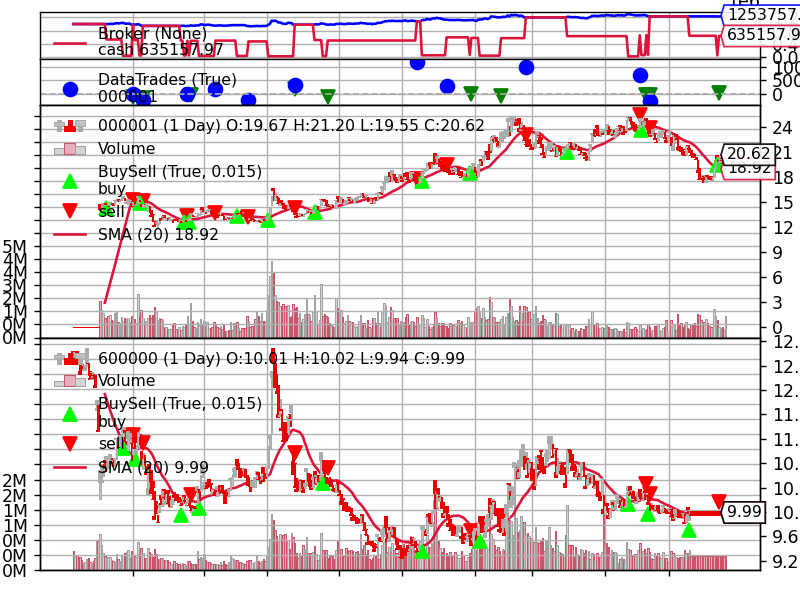

[[<Figure size 640x480 with 6 Axes>]]

In [17]:
cerebro.plot(style='candlestick')

展示夏普、年化收益率以及最大回撤等。本策略以日为单位进行计算，所以取252作为基准进行指标计算。同理可推，如果是以月为基准，则将252修改为12。

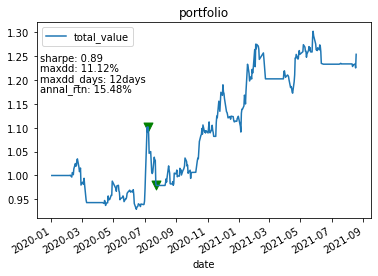

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

thestrat = thestrats[0]
pyfolio = thestrat.analyzers._pyfolio.get_analysis()
def plot_strategy(pyfolio):
    returns = pyfolio['returns'].values()
    returns = pd.DataFrame(list(zip(pyfolio['returns'].keys(),pyfolio['returns'].values())), columns=['date','total_value'])
    

    sharpe = np.round(np.sqrt(252) * returns['total_value'].mean() / returns['total_value'].std(), 4)
    returns['total_value']=returns['total_value']+1
    returns['total_value'] = returns['total_value'].cumprod()
    annal_rtn = np.round(returns['total_value'].iloc[-1]**(252/len(returns))-1, 4)*100
    dd = 1-returns['total_value']/np.maximum.accumulate(returns['total_value'])
    end_idx = np.argmax(dd)
    start_idx = np.argmax(returns['total_value'].iloc[:end_idx])
    maxdd_days = end_idx-start_idx
    maxdd = np.round(max(dd), 4)*100
    
    returns = returns.set_index('date')
    ax=returns.plot(y='total_value')
    plt.text(0.01,0.8, f'sharpe: {sharpe:.2f}', transform=ax.transAxes)
    plt.text(0.01,0.75, f'maxdd: {maxdd:.2f}%', transform=ax.transAxes)
    plt.text(0.01,0.7, f'maxdd_days: {maxdd_days:}days', transform=ax.transAxes)
    plt.text(0.01,0.65, f'annal_rtn: {(annal_rtn):.2f}%', transform=ax.transAxes)
    plt.scatter([returns.index[start_idx], returns.index[end_idx]], [returns.iloc[start_idx], returns.iloc[end_idx]],
                s = 80, c = 'g', marker = 'v', label = 'MaxDrawdown Duration')
    plt.title('portfolio')
    plt.show()

plot_strategy(pyfolio)